# Introduction

In this guided project, we're going to practice using our SQL skills to answer business questions. In each step, we'll need to:

 - Write a SQL query to extract the relevant data
 - Create plots where necessary to visualize the data
 - Write a short paragraph, drawing conclusions and explaining the data and/or visualizations.

# The Data

We'll continue to use the Chinook database that we've used in earlier missions of this course. The Chinook database is provided as a SQLite database file called `chinook.db`. A copy of the database schema is below:

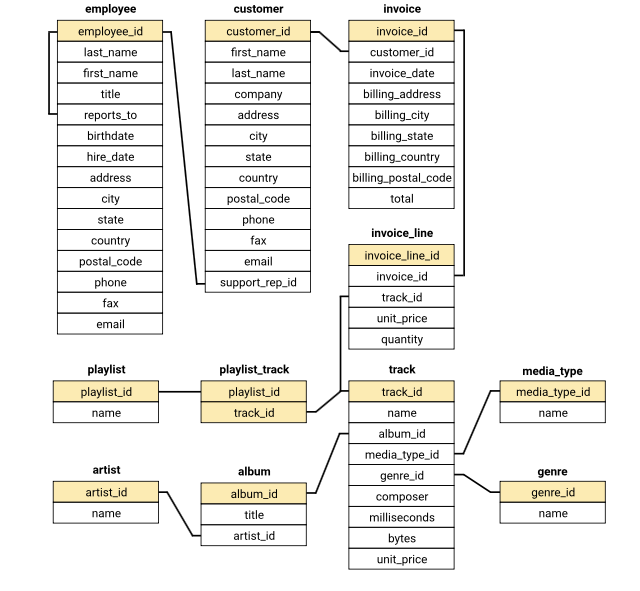

In [2]:
from IPython.display import Image
Image("chinookdbSchema.png")

We'll first load the needed modules:

In [33]:
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns

# This will need to be done in the future so 
# get accustomed to using now
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

%matplotlib inline


db = 'chinook.db'

## We'll define some helper functions to save some time

 - Create a `run_query()` function, that takes a SQL query as an argument and returns a pandas dataframe of that query.
 
 - Create a `run_command()` function that takes a SQL command as an argument and executes it using the sqlite module.
     - This function allows us to run SQL queries that don't return tables, like `CREATE VIEW`. In this instance, we don't need to use pandas, we can simply use the SQLite module's `connection.execute()` method.
     
 - Create a `show_tables()` function that calls the `run_query()` function to return a list of all tables and views in the database.
   -  This function uses our `run_query()` function to return a list of all tables and views in our databases - this is handy to quickly check the state of our database as we work.

In [5]:
# run_query takes a SQL query, returns a pandas DF

def run_query(q):
    with sqlite3.connect(db) as conn:
        return pd.read_sql(q, conn)

In [6]:
# run_command takes a SQL argument, executes with sqlite

def run_command(c):
    with sqlite3.connect(db) as conn:
        conn.isolation_level = None
        conn.execute(c)

In [7]:
# show_tables calls the run_query function to quickly show tables and views

def show_tables():
    q = '''
    SELECT
        name,
        type
    FROM sqlite_master
    WHERE type IN ("table","view");
    '''
    return run_query(q)

We'll now use the `show_tables` function:

In [8]:
show_tables()

,name,type
0,album,table
1,artist,table
2,customer,table
3,employee,table
4,genre,table
5,invoice,table
6,invoice_line,table
7,media_type,table
8,playlist,table
9,playlist_track,table


## Selecting Albums to Purchase

The Chinook record store has just signed a deal with a new record label, and you've been tasked with selecting the first three albums that will be added to the store, from a list of four. All four albums are by artists that don't have any tracks in the store right now - we have the artist names, and the genre of music they produce:

| Artist Name	| Genre |
|---------------|-------|
| Regal         | Hip-Hop |
|||
| Red Tone |  Punk  |
|||
| Meteor and the Girls | Pop |
|||
| Slim Jim Bites |	Blues |



The record label specializes in artists from the USA, and they have given Chinook some money to advertise the new albums in the USA, so we're interested in finding out which genres sell the best in the USA.


We'll next write a query that returns each genre, with the number of tracks sold in the USA:
 - in absolute numbers
 - in percentages.

In [50]:
q1 = '''
WITH usa_sales AS
    (
    SELECT
        g.name Genre,
        SUM(i.quantity) Tracks_sold
    FROM customer c
    INNER JOIN invoice inv ON inv.customer_id = c.customer_id
    INNER JOIN invoice_line i on i.invoice_id = inv.invoice_id
    INNER JOIN track t ON t.track_id = i.track_id
    INNER JOIN genre g ON t.genre_id = g.genre_id
    WHERE country = 'USA'
    GROUP BY Genre
    )

SELECT
    Genre,
    Tracks_sold,
    CAST(Tracks_sold AS FLOAT)/(SELECT SUM(Tracks_sold) FROM usa_sales) AS Percentage
FROM usa_sales
GROUP BY 2
ORDER BY 2 DESC;
'''


genre_and_sales = run_query(q1)

genre_and_sales

,Genre,Tracks_sold,Percentage
0,Rock,561,0.533777
1,Alternative & Punk,130,0.123692
2,Metal,124,0.117983
3,R&B/Soul,53,0.050428
4,Blues,36,0.034253
5,Alternative,35,0.033302
6,Latin,22,0.020932
7,Hip Hop/Rap,20,0.019029
8,Jazz,14,0.013321
9,Easy Listening,13,0.012369


## Visualizing our query

We'll now create a plot to show the data from our query.

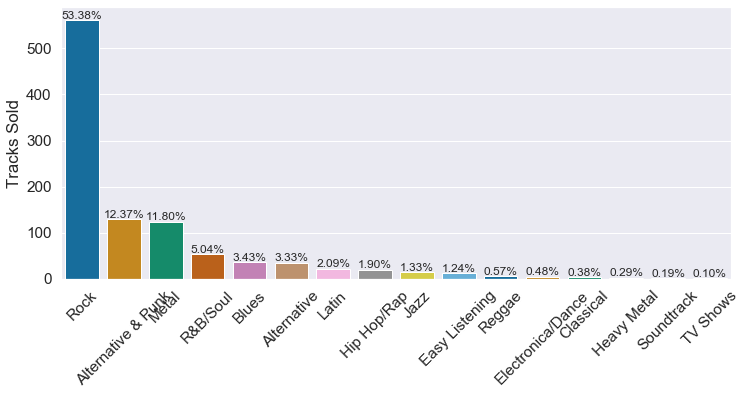

In [61]:
sns.set_style("whitegrid")
sns.set(font_scale=1.4)

fig = plt.figure(figsize=(12,5))
ax = sns.barplot(x="Genre", y="Tracks_sold", data=genre_and_sales, palette="colorblind")
ax.set_xticklabels(genre_and_sales['Genre'], rotation=45)
percent_labels = genre_and_sales['Percentage']
ax.set_xlabel('')
ax.set_ylabel('Tracks Sold')


sns.set(font_scale=1.0)

#Labels each bar with the percentage of sales.
for i in range(len(ax.patches)):
    p = ax.patches[i]
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}'.format(percent_labels.iloc[i]*100)+'%',
            ha="center") 
plt.show()

### Findings:

Based on the sales of tracks across different genres in the USA, we should purchase the new albums by the following artists:
 - Red Tone (Punk)
 - Slim Jim Bites (Blues)
 - Meteor and the Girls (Pop)

We should be on the lookout for artists and albums from the `rock` genre, which accounts for 53% of sales. The Punk, Blues, and Pop genres combined account for only 17% of total sales.

## Analyzing Employee Sales Performance

Each customer for the Chinook store gets assigned to a sales support agent within the company when they first make a purchase. We have been asked to analyze the purchases of customers belonging to each employee to see if any sales support agent is performing either better or worse than the others.

We'll write a query that finds the total dollar amount of sales assigned to each sales support agent within the company. We'll add any extra attributes for that employee that may be relevant to the analysis.

In [37]:
q2 = '''
WITH sales_employee AS
    (
    SELECT
        e.employee_id,
        e.first_name,
        e.last_name,
        SUM(i.total) total_sales
    FROM employee e
    INNER JOIN customer c ON c.support_rep_id = e.employee_id
    INNER JOIN invoice i ON i.customer_id = c.customer_id
    GROUP BY e.employee_id 
    )

SELECT
    s.first_name || ' ' || s.last_name Employee_name,
    e.hire_date Hire_date,
    s.total_sales Total_sales
FROM sales_employee s
INNER JOIN employee e ON e.employee_id = s.employee_id
ORDER BY 3 DESC;
'''


sales_per_agent = run_query(q2)

sales_per_agent

,Employee_name,Hire_date,Total_sales
0,Jane Peacock,2017-04-01 00:00:00,1731.51
1,Margaret Park,2017-05-03 00:00:00,1584.00
2,Steve Johnson,2017-10-17 00:00:00,1393.92


We included the `hire_date` data as it will influence the sales figures.

## Visualizing employee sales

We'll now create a plot to show the data from our query.

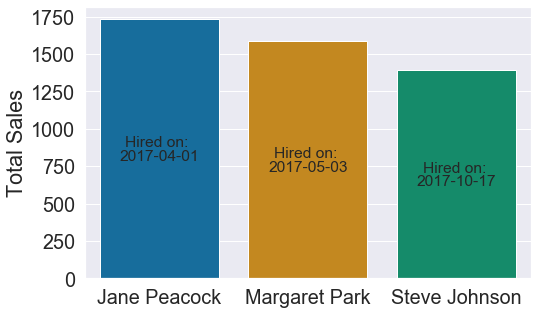

In [62]:


#Generates the bar plot.
sns.set(font_scale=1.8)
fig = plt.figure(figsize=(8,5))
ax = sns.barplot(x="Employee_name", y="Total_sales", data=sales_per_agent, palette="colorblind")
ax.set_xticklabels(sales_per_agent['Employee_name'])
ax.set_xlabel('')
ax.set_ylabel('Total Sales')

#Labels each bar with the percentage of sales.
sns.set(font_scale=1.3)
percent_labels = sales_per_agent['Hire_date'].apply(lambda x: x.split(' ')[0])
for i in range(len(ax.patches)):
    p = ax.patches[i]
    height = p.get_height()/2
    ax.text(p.get_x()+p.get_width()/2.,
            height + 15,
            'Hired on: ',
            ha="center") 
    ax.text(p.get_x()+p.get_width()/2.,
            height - 75,
            (percent_labels.iloc[i]),
            ha="center") 
plt.show()

### Findings:

There is approximately a 20% difference in sales between Jane (the top employee) and Steve (the bottom employee). However sales data will be heavily influenced by the `hire_date`. Our `employee` table doesn't give us information about employee leave or any other contributing factors. If we calculate the mean based on time in the company, there isn't that much difference.

Typically businesses use a quarterly statement to calculate earnings, so it may be useful in the future to add another table with relevant earnings data. 

## Sales by Country

Our next task is to analyze the sales data for customers from each different country. We've been given guidance to use the `country` value from the `customers` table, and ignore the `country` from the `billing_address` in the `invoice` table.

In particular, you have been directed to calculate data, for each country, on the:

 - total number of customers
 - total value of sales
 - average value of sales per customer
 - average order value

Because there are a number of countries with only one customer, We should group these customers as "Other" in our analysis.

Steps:

 - Write a query that collates data on purchases from different countries.

   - Where a country has only one customer, collect them into an "Other" group.

   - The results should be sorted by the total sales from highest to lowest, with the "Other" group at the very bottom.

   - For each country, include:
     - total number of customers
     - total value of sales
     - average value of sales per customer
     - average order value

In [43]:
q3 = '''
WITH sales_country AS
    (
    SELECT
        CASE
           WHEN (
                 SELECT count(*)
                 FROM customer 
                 where country = c.country
                ) = 1 THEN "Other"
           ELSE c.country
        END AS country,
        c.customer_id,
        SUM(i.total) customer_sales
    FROM customer c
    INNER JOIN invoice i ON c.customer_id = i.customer_id
    GROUP BY 2
    ),
    
    orders_country AS
    (
    SELECT
        c.country,
        AVG(i.total) average_country_order
    FROM customer c
    INNER JOIN invoice i ON c.customer_id = i.customer_id
    GROUP BY 1
    )
    

SELECT
    s.country,
    SUM(s.customer_sales) country_sales,
    COUNT(*) total_customers,
    SUM(s.customer_sales)/COUNT(*) average_value_of_sales_per_customer,
    average_country_order
FROM sales_country s
LEFT JOIN orders_country o ON o.country = s.country
GROUP BY 1 
ORDER BY CASE WHEN s.country = 'Other' THEN 2 ELSE 1 END, country_sales DESC

'''

sales_country = run_query(q3)

sales_country

,country,country_sales,total_customers,average_value_of_sales_per_customer,average_country_order
0,USA,1040.49,13,80.037692,7.942672
1,Canada,535.59,8,66.948750,7.047237
2,Brazil,427.68,5,85.536000,7.011148
3,France,389.07,5,77.814000,7.781400
4,Germany,334.62,4,83.655000,8.161463
5,Czech Republic,273.24,2,136.620000,9.108000
6,United Kingdom,245.52,3,81.840000,8.768571
7,Portugal,185.13,2,92.565000,6.383793
8,India,183.15,2,91.575000,8.721429
9,Other,1094.94,15,72.996000,NaN


## Visualizing sales by country

We'll now create a plot to show the data from our query.

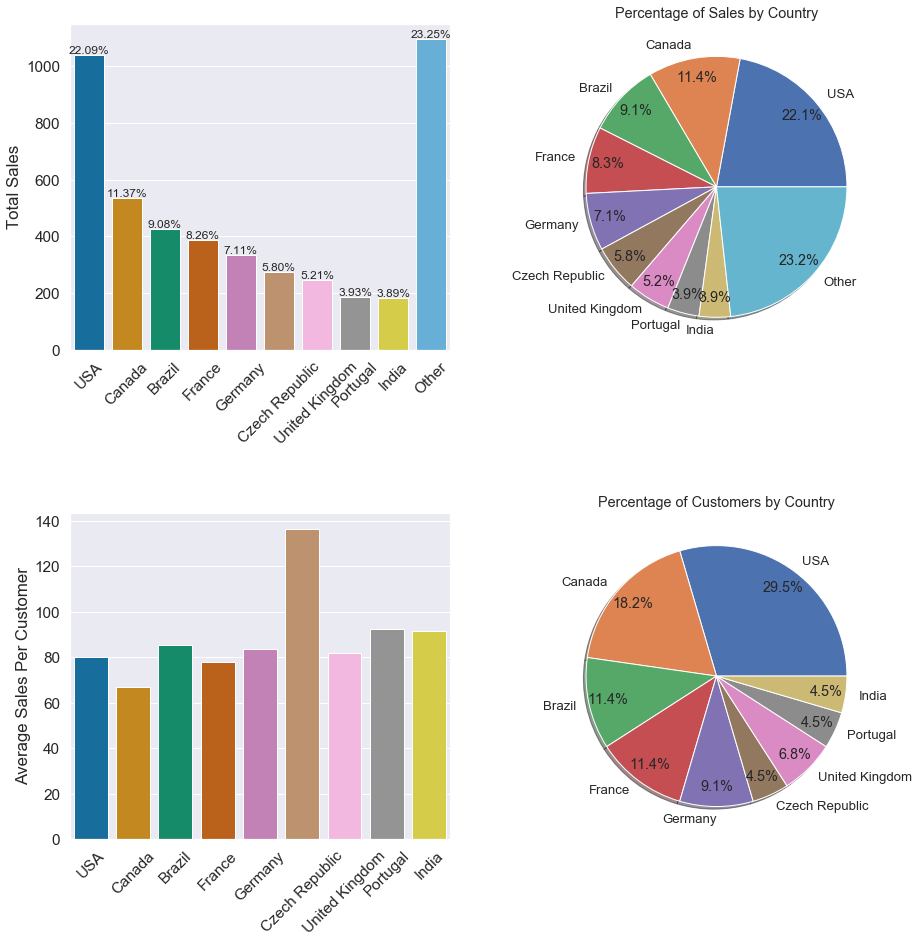

In [60]:
#Generates the sales bar plot.
sales_include_other = sales_country.loc[0:9]
sns.set(font_scale=1.4)
fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(2, 2, 1)
ax = sns.barplot(x="country", y="country_sales", data=sales_include_other, palette="colorblind")
ax.set_xticklabels(sales_include_other['country'], rotation=45)
ax.set_xlabel('')
ax.set_ylabel('Total Sales')

#Generate sales percentage labels.
sns.set(font_scale=1.0)
percent_labels = sales_include_other['country_sales']/sales_include_other['country_sales'].sum()
for i in range(len(ax.patches)):
    p = ax.patches[i]
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2,
            height + 5,
            '{:1.2f}'.format(percent_labels.iloc[i]*100)+'%',
            ha="center")
    
    
#Generate the top pie chart
sns.set(font_scale=1.2)
fig.subplots_adjust(hspace=.5)    
ax2 = fig.add_subplot(2, 2, 2)
ax2 = plt.pie(percent_labels, labels=sales_include_other["country"], autopct='%1.1f%%', shadow=True, pctdistance = 0.85)
plt.title('Percentage of Sales by Country')

#Generate the customer value bar plot
sales_exclude_other = sales_country.loc[0:8]
sns.set(font_scale=1.4)
ax3 = fig.add_subplot(2, 2, 3)
ax3 = sns.barplot(x="country", y="average_value_of_sales_per_customer", data=sales_exclude_other, palette='colorblind')
ax3.set_xticklabels(sales_exclude_other['country'], rotation=45)
ax3.set_xlabel('')
ax3.set_ylabel('Average Sales Per Customer')


#Generate the bottom pie chart
sns.set(font_scale=1.2)
percent_labels = sales_exclude_other['total_customers']/sales_exclude_other['total_customers'].sum()
ax4 = fig.add_subplot(2, 2, 4)
ax4 = plt.pie(percent_labels, labels=sales_exclude_other["country"], autopct='%1.1f%%', shadow=True, pctdistance = 0.85)
plt.title('Percentage of Customers by Country')

plt.show()

### Findings

Based on the data, there may be opportunity in the following countries:
 - Czech Republic
 - United Kingdom
 - India

The sample size is not large enough to give us high confidence, as the amount of data from each of these countries is relatively low. 

A cautious approach might be to run small marketing campaigns in these three countries, collecting and analyzing data from the new customers to make sure that these trends hold.

## Albums vs. Individual Tracks

The Chinook store is setup in a way that allows customer to make purchases in one of the two ways:

- purchase a whole album
 - purchase a collection of one or more individual tracks.

The store does not let customers purchase a whole album, and then add individual tracks to that same purchase (unless they do that by choosing each track manually). When customers purchase albums they are charged the same price as if they had purchased each of those tracks separately.

Management are currently considering changing their purchasing strategy to save money. The strategy they are considering is to purchase only the most popular tracks from each album from record companies, instead of purchasing every track from an album.

We have been asked to find out what percentage of purchases are individual tracks vs whole albums, so that management can use this data to understand the effect this decision might have on overall revenue.

It is very common when you are performing an analysis to have 'edge cases' which prevent you from getting a 100% accurate answer to your question. In this instance, we have two edge cases to consider:

 - Albums that have only one or two tracks are likely to be purchased by customers as part of a collection of individual tracks.
 - Customers may decide to manually select every track from an album, and then add a few individual tracks from other albums to their purchase.
 
In the first case, since our analysis is concerned with maximizing revenue we can safely ignore albums consisting of only a few tracks. 

The company has previously done analysis to confirm that the second case does not happen often, so we can ignore this case also.

Steps:

 - Write a query that categorizes each invoice as either an album purchase or not, and calculates the following summary statistics:
   - Number of invoices
   - Percentage of invoices
 
 - Make a prospective recommendation on whether the Chinook store should continue to buy full albums from record companies.

In [26]:
albums_vs_tracks = '''
WITH invoice_first_track AS
    (
     SELECT
         il.invoice_id invoice_id,
         MIN(il.track_id) first_track_id
     FROM invoice_line il
     GROUP BY 1
    )

SELECT
    album_purchase,
    COUNT(invoice_id) number_of_invoices,
    CAST(count(invoice_id) AS FLOAT) / (
                                         SELECT COUNT(*) FROM invoice
                                      ) percent
FROM
    (
    SELECT
        ifs.*,
        CASE
            WHEN
                 (
                  SELECT t.track_id FROM track t
                  WHERE t.album_id = (
                                      SELECT t2.album_id FROM track t2
                                      WHERE t2.track_id = ifs.first_track_id
                                     ) 

                  EXCEPT 

                  SELECT il2.track_id FROM invoice_line il2
                  WHERE il2.invoice_id = ifs.invoice_id
                 ) IS NULL
             AND
                 (
                  SELECT il2.track_id FROM invoice_line il2
                  WHERE il2.invoice_id = ifs.invoice_id

                  EXCEPT 

                  SELECT t.track_id FROM track t
                  WHERE t.album_id = (
                                      SELECT t2.album_id FROM track t2
                                      WHERE t2.track_id = ifs.first_track_id
                                     ) 
                 ) IS NULL
             THEN "yes"
             ELSE "no"
         END AS "album_purchase"
     FROM invoice_first_track ifs
    )
GROUP BY album_purchase;
'''

run_query(albums_vs_tracks)

,album_purchase,number_of_invoices,percent
0,no,500,0.814332
1,yes,114,0.185668


### Findings:

Album purchases account for 18.6% of purchases. Based on this data, I would recommend against purchasing only select tracks from albums from record companies, since there is potential to lose one fifth of revenue.

## Finding Highest Revenue Album

Here we'll take a look at where our revenue is coming from by album.

In [39]:
q7 = '''
WITH invoice_detailed AS
    (SELECT
        a.album_id,
        a.title,
        t.track_id,
        i.invoice_id,
        (i.total) total
    FROM
        track t
    INNER JOIN invoice_line il ON il.track_id = t.track_id
    INNER JOIN invoice i ON i.invoice_id = il.invoice_id
    INNER JOIN album a ON a.album_id = t.album_id
    GROUP BY i.invoice_id
    ),
    
    songs AS
    (
    SELECT 
        album_id album_key,
        count(*) number_of_songs
    FROM 
        track
    GROUP BY album_key
    )
    
SELECT
    album_id,
    title,
    SUM(total),
    count(*) copies_sold,
    number_of_songs,
    CAST (SUM(total) AS FLOAT)/(number_of_songs) Revenue_per_song      
FROM 
    (
    SELECT
        ivd.*,
        CASE
            WHEN
                (
                SELECT t.track_id FROM track t 
                WHERE t.album_id = (
                                    SELECT t2.album_id FROM track t2 
                                    WHERE t2.track_id = ivd.track_id
                                    )
                EXCEPT 

                SELECT il2.track_id FROM invoice_line il2
                WHERE il2.invoice_id = ivd.invoice_id
                ) IS NULL
             AND
                (
                SELECT il2.track_id FROM invoice_line il2
                WHERE il2.invoice_id = ivd.invoice_id

                EXCEPT 

                SELECT t.track_id FROM track t
                WHERE t.album_id = (
                                    SELECT t2.album_id FROM track t2
                                    WHERE t2.track_id = ivd.track_id
                                    ) 
                ) IS NULL                                  
            THEN 'Yes'
            ELSE 'No'
        END AS 'album_purchase'
    FROM invoice_detailed ivd
    ) q
INNER JOIN songs s ON s.album_key = q.album_id 
WHERE album_purchase = 'Yes' 
GROUP BY album_id
ORDER BY copies_sold DESC
LIMIT 5
'''

album_sales = run_query(q7)
album_sales

,album_id,title,SUM(total),copies_sold,number_of_songs,Revenue_per_song
0,120,Are You Experienced?,100.98,6,17,5.94
1,186,News Of The World,43.56,4,11,3.96
2,119,Get Born,51.48,4,13,3.96
3,188,Green,32.67,3,11,2.97
4,157,Miles Ahead,41.58,3,14,2.97


## Visualizing our query


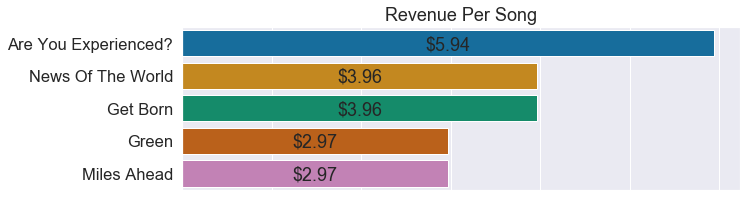

In [59]:
#Figure settings
sns.set(font_scale=1.5)
fig = plt.figure(figsize=(10,3))

#Generate the bar plot
ax = fig.add_subplot(1, 1, 1)
ax = sns.barplot(y="title", x="Revenue_per_song", data=album_sales, palette="colorblind")
ax.set_ylabel('')
ax.set_xlabel('')
ax.set_xticklabels('')
plt.title('Revenue Per Song') 

#Generate Revenue_per_song labels.
percent_labels = album_sales['Revenue_per_song']
for i in range(len(ax.patches)):
    p = ax.patches[i]
    width = p.get_width()
    ax.text(width/2,
            p.get_y()+p.get_height()-0.2,
            '$'+'{:1.2f}'.format(percent_labels.iloc[i]),
            ha="center")
plt.show()

### Findings

The best performing album from our limited sample size of 6 is, 'Are You Experienced?', generating $5.94 per song.
We should gather more data before making any business decisions.

## Determining the MVP Artists

We will take a look at the average revenue per song and categorize it by the artist's name. This will help us understand if there are any standouts. 

In [41]:
q8 = '''
WITH invoice_line_detailed AS
    (
    SELECT
        ar.artist_id,
        ar.name,
        il.quantity,
        il.unit_price
    FROM
        track t
    INNER JOIN invoice_line il ON il.track_id = t.track_id
    INNER JOIN album a ON a.album_id = t.album_id
    INNER JOIN artist ar ON ar.artist_id = a.artist_id
    ),

    tracks_artist AS
    (
    SELECT
        a.artist_id artist_key,
        count(*) songs_in_shop
    FROM
        track t
    INNER JOIN album a ON a.album_id = t.album_id
    INNER JOIN artist ar ON ar.artist_id = a.artist_id
    GROUP BY artist_key
    )

SELECT
    artist_id,
    name Artist,
    SUM(quantity) songs_sold,
    SUM(unit_price) revengue_generated,
    songs_in_shop,
    SUM(unit_price)/CAST (songs_in_shop AS FLOAT) revenue_per_song
FROM invoice_line_detailed ivd
INNER JOIN tracks_artist ta on ta.artist_key = ivd.artist_id 
GROUP BY name
ORDER BY revenue_per_song DESC
'''


artist_sales = run_query(q8)
top_five_artists = artist_sales.iloc[0:5]
top_five_artists

,artist_id,Artist,songs_sold,revengue_generated,songs_in_shop,revenue_per_song
0,196,Cake,31,30.69,1,30.69
1,94,Jimi Hendrix,187,185.13,17,10.89
2,253,Calexico,10,9.90,1,9.90
3,135,System Of A Down,93,92.07,11,8.37
4,227,Luciano Pavarotti,8,7.92,1,7.92


### Visualizing our query


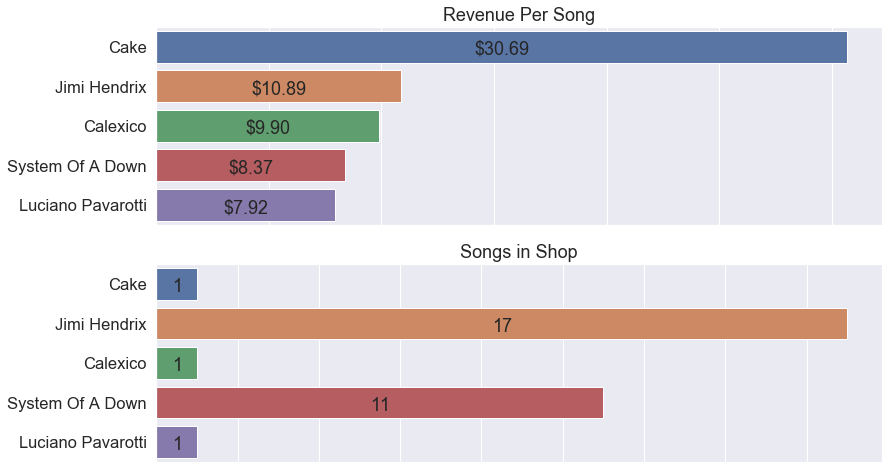

In [42]:
#Figure settings
sns.set(font_scale=1.5)
fig = plt.figure(figsize=(13,8))


#Generate the top bar plot
ax = fig.add_subplot(2, 1, 1)
ax = sns.barplot(y="Artist", x="revenue_per_song", data=top_five_artists, palette="deep")
ax.set_ylabel('')
ax.set_xlabel('')
ax.set_xticklabels('')
plt.title('Revenue Per Song') 

#Generate revenue_per_song labels.
labels = top_five_artists['revenue_per_song']
for i in range(len(ax.patches)):
    p = ax.patches[i]
    width = p.get_width()
    ax.text(width/2,
            p.get_y()+p.get_height()-0.2,
            '$'+'{:1.2f}'.format(labels.iloc[i]),
            ha="center")
    
#Generate the bottom bar plot
ax = fig.add_subplot(2, 1, 2)
ax = sns.barplot(y="Artist", x="songs_in_shop", data=top_five_artists, palette="deep")
ax.set_ylabel('')
ax.set_xlabel('')
ax.set_xticklabels('')
plt.title('Songs in Shop') 

#Generate 'Songs in Shop' labels.
percent_labels = top_five_artists['songs_in_shop']
for i in range(len(ax.patches)):
    p = ax.patches[i]
    width = p.get_width()
    ax.text(width/2,
            p.get_y()+p.get_height()-0.2,
            '{:1.0f}'.format(percent_labels.iloc[i]),
            ha="center")
plt.show()

### Findings

Immediately we see that the artist "Cake" has only one song in shop. However, this one song generated the most revenue($30.69/song) in the entire shop. The artists 'Calexico' and 'Gustav Mahler' also only have one song in our shop.

These artists may be quite popular, yet customers can only find one of their songs in our shop. We could be missing out on potential sales. We should perform more research on these artists to see if there are songs by them with similar popularity so that we can expand our inventory and grow sales.  

## Which artist is used in the most playlists?

We'll now take a closer look at playlists.

In [29]:
top_artist_playlist = '''
WITH artists_by_playlist AS
    (
    SELECT 
        pt.playlist_id,
        ar.name as artist_name,
        ar.artist_id
    FROM track t
    INNER JOIN playlist_track pt on pt.track_id = t.track_id
    INNER JOIN album al on al.album_id = t.album_id
    INNER JOIN artist ar on ar.artist_id = al.artist_id
    GROUP BY 1,2
    ORDER BY 1
    )

SELECT
    artist_name,
    COUNT(artist_id) as artist_frequency
FROM artists_by_playlist
GROUP BY artist_id
ORDER by 2 DESC
LIMIT 1
'''
run_query(top_artist_playlist)

,artist_name,artist_frequency
0,Eugene Ormandy,7


#### Observations

Eugene Ormandy is a classical artist from the USA. The fact that a classical artist is the artist most used in playlists leads us to wonder what genre of music are used in most playlists. Let's take a closer look.

In [30]:
top_genre_playlist = '''
WITH genre_by_playlist AS
    (
    SELECT 
        pt.playlist_id,
        g.name as genre_name,
        g.genre_id
    FROM track t
    INNER JOIN playlist_track pt on pt.track_id = t.track_id
    INNER JOIN genre g on g.genre_id = t.genre_id
    GROUP BY 1,3
    ORDER BY pt.playlist_id
    )

SELECT
    genre_name,
    COUNT(genre_id) as genre_frequency
FROM genre_by_playlist
GROUP BY genre_id
ORDER by 2 DESC
LIMIT 3
'''
run_query(top_genre_playlist)

,genre_name,genre_frequency
0,Classical,7
1,Opera,5
2,Alternative,5


## Most popular genre : Purchases vs Playlists


7 of 18 playlists contain classical music, which makes it the most used genre in playlists.

We will now look at any possible correlation between this playlist content with sales numbers. 


In [31]:
genre_purchased = '''
WITH tracks_sold AS
   (
    SELECT il.* FROM invoice_line il
    INNER JOIN invoice i on il.invoice_id = i.invoice_id
    INNER JOIN customer c on i.customer_id = c.customer_id
   )

SELECT
    g.name genre,
    count(ts.invoice_line_id) tracks_sold
FROM tracks_sold ts
INNER JOIN track t on t.track_id = ts.track_id
INNER JOIN genre g on g.genre_id = t.genre_id
GROUP BY 1
ORDER BY 2 DESC
LIMIT 10;
'''

run_query(genre_purchased)

,genre,tracks_sold
0,Rock,2635
1,Metal,619
2,Alternative & Punk,492
3,Latin,167
4,R&B/Soul,159
5,Blues,124
6,Jazz,121
7,Alternative,117
8,Easy Listening,74
9,Pop,63


#### Observations

As before Rock is by far the most purchased music genre in our store. This leads us to question the relevance of the content proposed in our playlists and to know if it aligns with the type of music sold.

The content of playlists may be related to current musical trends. It would be interesting to find out what kind of music has been most purchased in the last two years (2018 and 2019).

In [32]:
recent_genre_purchased = '''
WITH tracks_sold AS
   (
    SELECT 
        il.* ,
        i.invoice_date as invoice_date,
        strftime('%Y',invoice_date) as year_purchase
    FROM invoice_line il
    INNER JOIN invoice i on il.invoice_id = i.invoice_id
    INNER JOIN customer c on i.customer_id = c.customer_id
    WHERE strftime('%Y',invoice_date) = "2019" OR strftime('%Y',invoice_date) = "2018"
    )

SELECT
    g.name genre,
    count(ts.invoice_line_id) tracks_sold
FROM tracks_sold ts
INNER JOIN track t on t.track_id = ts.track_id
INNER JOIN genre g on g.genre_id = t.genre_id
GROUP BY 1
ORDER BY 2 DESC
LIMIT 10;
'''

run_query(recent_genre_purchased)

,genre,tracks_sold
0,Rock,1264
1,Metal,345
2,Alternative & Punk,285
3,Latin,91
4,Blues,70
5,R&B/Soul,58
6,Easy Listening,49
7,Alternative,48
8,Jazz,43
9,Electronica/Dance,42


#### Observations

Historical data aligns with the popularity of the music genres of the last two years. We should review the content of the playlists and to adapt it to the sales trends.